#### Aim: of this notebook is to get a timestamp-scan mapping AND AMCL pose prediction for ROS

In [1]:
import rosbag
import matplotlib.pyplot as plt

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
import sensor_msgs.point_cloud2 as pc2
import rospy
from sensor_msgs.msg import PointCloud2, LaserScan
import math
import rosbag
import matplotlib.pyplot as plt
import pickle

In [3]:
import open3d as o3d
import numpy as np
import copy
import json

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [65]:
import importlib
import helper_utils.traj_maker
importlib.reload(helper_utils.traj_maker)

<module 'helper_utils.traj_maker' from '/home/anmolagarwal/Desktop/mr_mcl_project/analysis_based_stuff/helper_utils/traj_maker.py'>

#### Plot trajectory with steps

In [5]:
EXP_NAME = "exp_1"

In [6]:
bag_file_name = "/home/anmolagarwal/Desktop/bag_by_parth.bag"
bag = rosbag.Bag(bag_file_name)
all_timestamps = []
amcl_poses = []
for topic, msg, t in bag.read_messages(topics=['/amcl_pose']):
    #print(msg)
    #print(msg.header.stamp)
    all_timestamps.append(msg.header.stamp)
    amcl_poses.append(   [msg.header.stamp, msg.pose.pose     ])
    #print("###########################")
    #break
bag.close()

amcl_poses_df = []
with open(EXP_NAME+"/"+"amcl_poses.tum", 'w') as fd:
    for curr_elem in amcl_poses:
        ts = curr_elem[0].secs + curr_elem[0].nsecs*(10**(-9))
        x = curr_elem[1].position.x
        y = curr_elem[1].position.y
        z = curr_elem[1].position.z
        q_x = curr_elem[1].orientation.x
        q_y = curr_elem[1].orientation.y
        q_z = curr_elem[1].orientation.z
        q_w = curr_elem[1].orientation.w
        str_to_write = f"{ts} {x} {y} {z} {q_x} {q_y} {q_z} {q_w}"
        fd.write(str_to_write+"\n")
        
        curr_obj = dict()
        curr_obj['ts'] = ts
        curr_obj['x'] = x
        curr_obj['y'] = y
        curr_obj['z'] = z
        curr_obj['q_x'] = q_x
        curr_obj['q_y'] = q_y
        curr_obj['q_z'] = q_z
        curr_obj['q_w'] = q_w
        amcl_poses_df.append(curr_obj)
        #break

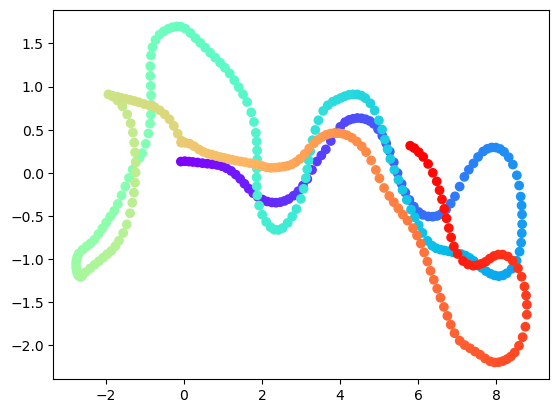

In [7]:
x_arr = [x['x'] for x in amcl_poses_df]
y_arr = [x['y'] for x in amcl_poses_df]
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(y_arr)))
plt.scatter(x_arr, y_arr, color=colors)

In [8]:
list(zip(x_arr, y_arr))

[(-0.08165548836699942, 0.13097753673226195),
 (0.019724510464253327, 0.13570968617212473),
 (0.12445650806162652, 0.13095296632700057),
 (0.22542338819579466, 0.12613697867908355),
 (0.3463198307758865, 0.11991279924854747),
 (0.47103117965021196, 0.11239310904826244),
 (0.5978737580772706, 0.10598489623056859),
 (0.7202979802378552, 0.09926185828264114),
 (0.8471925504118708, 0.09157069564794508),
 (0.9678202810390225, 0.07770536478607541),
 (1.0850503898005532, 0.054160292986243565),
 (1.2063974408719602, 0.022207966452749747),
 (1.323014166707665, -0.01985206003485873),
 (1.4375978377347185, -0.0697396760359987),
 (1.5471901517665971, -0.12629813365539302),
 (1.6566349106743246, -0.18320835950384307),
 (1.7721944431586325, -0.23580710825062087),
 (1.8887082226478271, -0.27806639132630107),
 (2.007436690370169, -0.3093905862107393),
 (2.127046460016224, -0.3316039865558178),
 (2.2475136625838505, -0.3431760218183437),
 (2.3557948996206295, -0.3465144349200717),
 (2.463444613084596, 

In [9]:
def fetch_pcd_obj(pcd_json):
    pts_arr = []
    master_pcd=o3d.geometry.PointCloud()
    for curr_elem in pcd_json:
        pts_arr.append([curr_elem['x'],curr_elem['y'], curr_elem['z'] ])
    master_pcd.points = o3d.utility.Vector3dVector(np.asarray(pts_arr))
    return master_pcd

#### Load the scans which needed to be queried

In [10]:
import json
with open("exp_1/traj_df.json",'r') as fd:
    traj_df = json.load(fd)

In [11]:
len(traj_df)

2625

In [12]:
for curr_elem in traj_df:
    curr_elem['pcd_obj'] = fetch_pcd_obj(curr_elem['point_list'])
    R = curr_elem['pcd_obj'].get_rotation_matrix_from_xyz((0, 0, -np.pi / 2))
    curr_elem['pcd_obj'].rotate(R, center=(0, 0, 0))
    curr_elem['pcd_obj'].estimate_normals()
    curr_elem['pcd_obj'].paint_uniform_color([1, 0, 0])

#### Load the database

In [13]:
with open("more_filtered_points_df_high_res.json", 'r') as fd:
    points_df = json.load(fd)

In [14]:
for curr_elem in points_df:
    curr_elem['pcd_obj'] = fetch_pcd_obj(curr_elem['point_list'])

In [15]:
len(points_df)

15756

In [16]:
max([x['x'] for x in points_df]), min([x['x'] for x in points_df])

(3.9, 0.0)

In [17]:
max([x['y'] for x in points_df]), min([x['y'] for x in points_df])

(0.4, -1.2)

### Make a function which takes the area of the database to be searched and returns the score for each entry in the database

In [18]:
points_df[0]

{'y': -1.2,
 'x': 0.0,
 'point_list': [{'y': -0.34926852583885193,
   'x': 0.0002781136427074671,
   'intensity': 0.0,
   'z': 0.0,
   'index': 0},
  {'y': -0.35512083768844604,
   'x': 0.0015162777854129672,
   'intensity': 0.0,
   'z': 0.0,
   'index': 1},
  {'y': -0.3619011640548706,
   'x': 0.0028023207560181618,
   'intensity': 0.0,
   'z': 0.0,
   'index': 2},
  {'y': -0.34852364659309387,
   'x': 0.003909424412995577,
   'intensity': 0.0,
   'z': 0.0,
   'index': 3},
  {'y': -0.34129616618156433,
   'x': 0.005014028865844011,
   'intensity': 0.0,
   'z': 0.0,
   'index': 4},
  {'y': -0.3669690787792206,
   'x': 0.006666187196969986,
   'intensity': 0.0,
   'z': 0.0,
   'index': 5},
  {'y': -0.35869312286376953,
   'x': 0.007762248162180185,
   'intensity': 0.0,
   'z': 0.0,
   'index': 6},
  {'y': -0.3775108754634857,
   'x': 0.009481455199420452,
   'intensity': 0.0,
   'z': 0.0,
   'index': 7},
  {'y': -0.3655490279197693,
   'x': 0.010451658628880978,
   'intensity': 0.0,
   

In [19]:
o3d.visualization.draw_geometries([traj_df[0]['pcd_obj']])

### Sort the entries via score and find the best entry"

In [20]:
scores_arr = helper_utils.traj_maker.fetch_best_contenders(points_df, traj_df[0], -1000, 1000, -1000, 1000)

In [21]:
scores_arr= sorted(scores_arr,key=lambda x:x[2].inlier_rmse)

In [22]:
def fetch_trans_mag(t):
    #print(t)
    arr = t[:2, -1]
    #print(arr)
    return arr[0]**2+arr[1]**2

In [23]:
fetch_trans_mag(scores_arr[0][2].transformation)

0.013641447681413075

In [24]:
scores_arr[0][2].transformation

array([[ 0.99744443, -0.07144654,  0.        ,  0.01967558],
       [ 0.07144654,  0.99744443,  0.        , -0.1151274 ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [25]:
#scores_arr= sorted(scores_arr,key=lambda x:fetch_trans_mag(x[2].transformation))

In [26]:
scores_arr

[(1224,
  RegistrationResult with fitness=1.988827e-01, inlier_rmse=9.860889e-02, and correspondence_set size of 178
  Access transformation to get result.,
  RegistrationResult with fitness=1.000000e+00, inlier_rmse=7.637328e-01, and correspondence_set size of 895
  Access transformation to get result.),
 (3911,
  RegistrationResult with fitness=6.703911e-02, inlier_rmse=1.077821e-01, and correspondence_set size of 60
  Access transformation to get result.,
  RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.368042e+00, and correspondence_set size of 895
  Access transformation to get result.),
 (2016,
  RegistrationResult with fitness=3.162011e-01, inlier_rmse=7.966627e-02, and correspondence_set size of 283
  Access transformation to get result.,
  RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.452152e+00, and correspondence_set size of 895
  Access transformation to get result.),
 (1200,
  RegistrationResult with fitness=3.106145e-01, inlier_rmse=7.321320e-02

In [27]:
#o3d.visualization.draw_geometries([points_df[3857]['pcd_obj'], traj_df[0]['pcd_obj']])

In [28]:
#o3d.visualization.draw_geometries([points_df[2790]['pcd_obj'], traj_df[0]['pcd_obj']])

In [29]:
#o3d.visualization.draw_geometries([points_df[12227]['pcd_obj']])

In [30]:
#points_df[0]

#### Draw best candidates

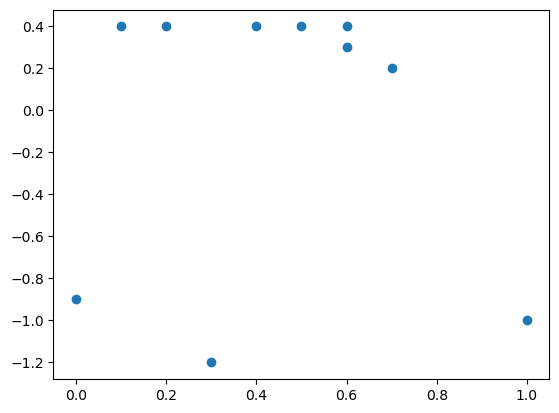

In [31]:
num_candidates = 10
top_indexes = [x[0] for x in scores_arr[:num_candidates]]
x_c = [points_df[idx]['x'] for idx in top_indexes]
y_c = [points_df[idx]['y'] for idx in top_indexes]
plt.scatter(x_c, y_c)

In [32]:
num_candidates

10

### Draw the trajectory and compare it with the ground truth

In [66]:
def plot_pcds(query_pcd, transformed_pcd):
    pass

In [67]:
pred_traj_idx = []
y_min = -1000
x_min = -1000
y_max = 1000
x_max = 1000

'''y_min = -1
x_min = 0
y_max = 0.4
x_max = 1'''

for traj_id, curr_traj_elem in enumerate(traj_df[:1:100]):
    print("TRAJ ID IS ", traj_id)
    print(x_min, x_max, y_min, y_max)
    scores_arr = helper_utils.traj_maker.fetch_best_contenders(points_df, curr_traj_elem, x_min, x_max, y_min, y_max)
    scores_arr= sorted(scores_arr,key=lambda x:x[2].inlier_rmse)
    best_idx = scores_arr[0][0]
    print(scores_arr[0])
    pred_traj_idx.append(best_idx)
    #x_min, x_max = points_df[best_idx]['x']-0.5,  points_df[best_idx]['x']+0.5
    #y_min, y_max = points_df[best_idx]['y']-0.5,  points_df[best_idx]['y']+0.5
    pass
    break

TRAJ ID IS  0
-1000 1000 -1000 1000
(11290, RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.399013e-01, and correspondence_set size of 896
Access transformation to get result., RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.399013e-01, and correspondence_set size of 896
Access transformation to get result.)


In [68]:
scores_arr

[(11290,
  RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.399013e-01, and correspondence_set size of 896
  Access transformation to get result.,
  RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.399013e-01, and correspondence_set size of 896
  Access transformation to get result.),
 (11698,
  RegistrationResult with fitness=9.966443e-01, inlier_rmse=1.405323e-01, and correspondence_set size of 891
  Access transformation to get result.,
  RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.449758e-01, and correspondence_set size of 894
  Access transformation to get result.),
 (11314,
  RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.502934e-01, and correspondence_set size of 896
  Access transformation to get result.,
  RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.502934e-01, and correspondence_set size of 896
  Access transformation to get result.),
 (11722,
  RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.51347

In [69]:
o3d.visualization.draw_geometries([curr_traj_elem['pcd_obj']     ,   points_df[2766]['pcd_obj']      ])

In [72]:
o3d.visualization.draw_geometries([curr_traj_elem['pcd_obj']     ,   points_df[best_idx]['pcd_obj']      ])

In [71]:
eeeeeeeeeeeeeeeeeeeee

NameError: name 'eeeeeeeeeeeeeeeeeeeee' is not defined

In [ ]:
x1 = np.asarray(points_df[best_idx]['pcd_obj'].points)[:, 0]
y1 = np.asarray(points_df[best_idx]['pcd_obj'].points)[:, 1]
x2 = np.asarray(curr_traj_elem['pcd_obj'].points)[:, 0]
y2 = np.asarray(curr_traj_elem['pcd_obj'].points)[:, 1]
plt.scatter(x1, y1, color='blue')
plt.scatter(x2, y2, color='red')

In [ ]:
pred_traj_idx

In [ ]:
x_arr_2 = [points_df[idx]['x'] for idx in pred_traj_idx]
y_arr_2 = [points_df[idx]['y'] for idx in pred_traj_idx]
import matplotlib.pyplot as plt
import matplotlib.cm as cm
num_cols = 10
colors = cm.rainbow(np.linspace(0, 1, len(y_arr_2)))
plt.plot(x_arr_2[:num_cols], y_arr_2[:num_cols], '--')

In [ ]:
x_arr = [x['x'] for x in amcl_poses_df]
y_arr = [x['y'] for x in amcl_poses_df]
import matplotlib.pyplot as plt
import matplotlib.cm as cm

x_arr_2 = [points_df[idx]['x'] for idx in pred_traj_idx]
y_arr_2 = [points_df[idx]['y'] for idx in pred_traj_idx]
import matplotlib.pyplot as plt
import matplotlib.cm as cm
num_cols = 10
colors = cm.rainbow(np.linspace(0, 1, len(y_arr_2)))
plt.plot(x_arr_2[:num_cols], y_arr_2[:num_cols], '--')

colors = cm.rainbow(np.linspace(0, 1, len(y_arr)))
plt.scatter(x_arr, y_arr, color=colors)